# Sentiment Analysis with BERT in spanish

This one is made with BERT, being precise, with the BNE base model altogether with the MuchoCine movies review dataset.

Inspired in [this notebook](https://github.com/curiousily/Getting-Things-Done-with-Pytorch/blob/master/08.sentiment-analysis-with-bert.ipynb)

In [1]:
!nvidia-smi

Fri Sep  3 14:16:55 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.63.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   71C    P8    32W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
!pip install -q -U watermark

In [3]:
!pip install -qq transformers

     |████████████████████████████████| 2.8 MB 5.3 MB/s 
     |████████████████████████████████| 50 kB 6.3 MB/s 
     |████████████████████████████████| 895 kB 36.8 MB/s 
     |████████████████████████████████| 636 kB 41.4 MB/s 
     |████████████████████████████████| 3.3 MB 41.4 MB/s 


In [4]:
%reload_ext watermark
%watermark -v -p numpy,pandas,torch,transformers

Python implementation: CPython
Python version       : 3.7.11
IPython version      : 5.5.0

numpy       : 1.19.5
pandas      : 1.1.5
torch       : 1.9.0+cu102
transformers: 4.10.0



In [5]:
#@title Setup & Config

from pylab import rcParams
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)
rcParams['figure.figsize']= 12,8

## Dataset Exploration

In [6]:
!pip install -qq datasets

     |████████████████████████████████| 264 kB 5.3 MB/s 
     |████████████████████████████████| 119 kB 35.0 MB/s 
     |████████████████████████████████| 243 kB 38.5 MB/s 


In [7]:
from datasets import load_dataset

In [8]:
dataset = load_dataset('muchocine')
dataset = dataset['train']

Downloading:   0%|          | 0.00/1.54k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/558 [00:00<?, ?B/s]

Using custom data configuration default


Downloading:   0%|          | 0.00/55.6M [00:00<?, ?B/s]

0 examples [00:00, ? examples/s]

Dataset muchocine downloaded and prepared to /root/.cache/huggingface/datasets/muchocine/default/1.1.1/3ed5582584cd84ef722606a3d725ef18fd4647d63195fef05c47683e5a056ccd. Subsequent calls will reuse this data.


In [9]:
print(dataset.description)

The Muchocine reviews dataset contains 3,872 longform movie reviews in Spanish language,
each with a shorter summary review, and a rating on a 1-5 scale.



In [10]:
dataset.features

{'review_body': Value(dtype='string', id=None),
 'review_summary': Value(dtype='string', id=None),
 'star_rating': Value(dtype='int32', id=None)}

In [11]:
dataset = dataset.to_pandas()

In [12]:
dataset.sample(5)

,review_body,review_summary,star_rating
2411,"Si ya lo decía yo, nada bueno sale del híbrido...","No es una película de Jack Black, sino de Jare...",1
2244,Tan mala y predecible como me esperaba. No cab...,Saw IV cae de nuevo en lo tópico para disimula...,1
2114,Hay cierta cinefilia de talante estricto y de ...,Es como si ahora nos pusiéramos a hacer semiót...,2
2465,"Como suele ser costumbre en este sitio, retome...",El gran mérito de la película es su capacidad ...,3
367,Dos momentos definen a la perfección qué supon...,Una película que apela a la nostalgia de un pe...,3


In [13]:
dataset.shape

(3872, 3)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 0, 'Star Rating')

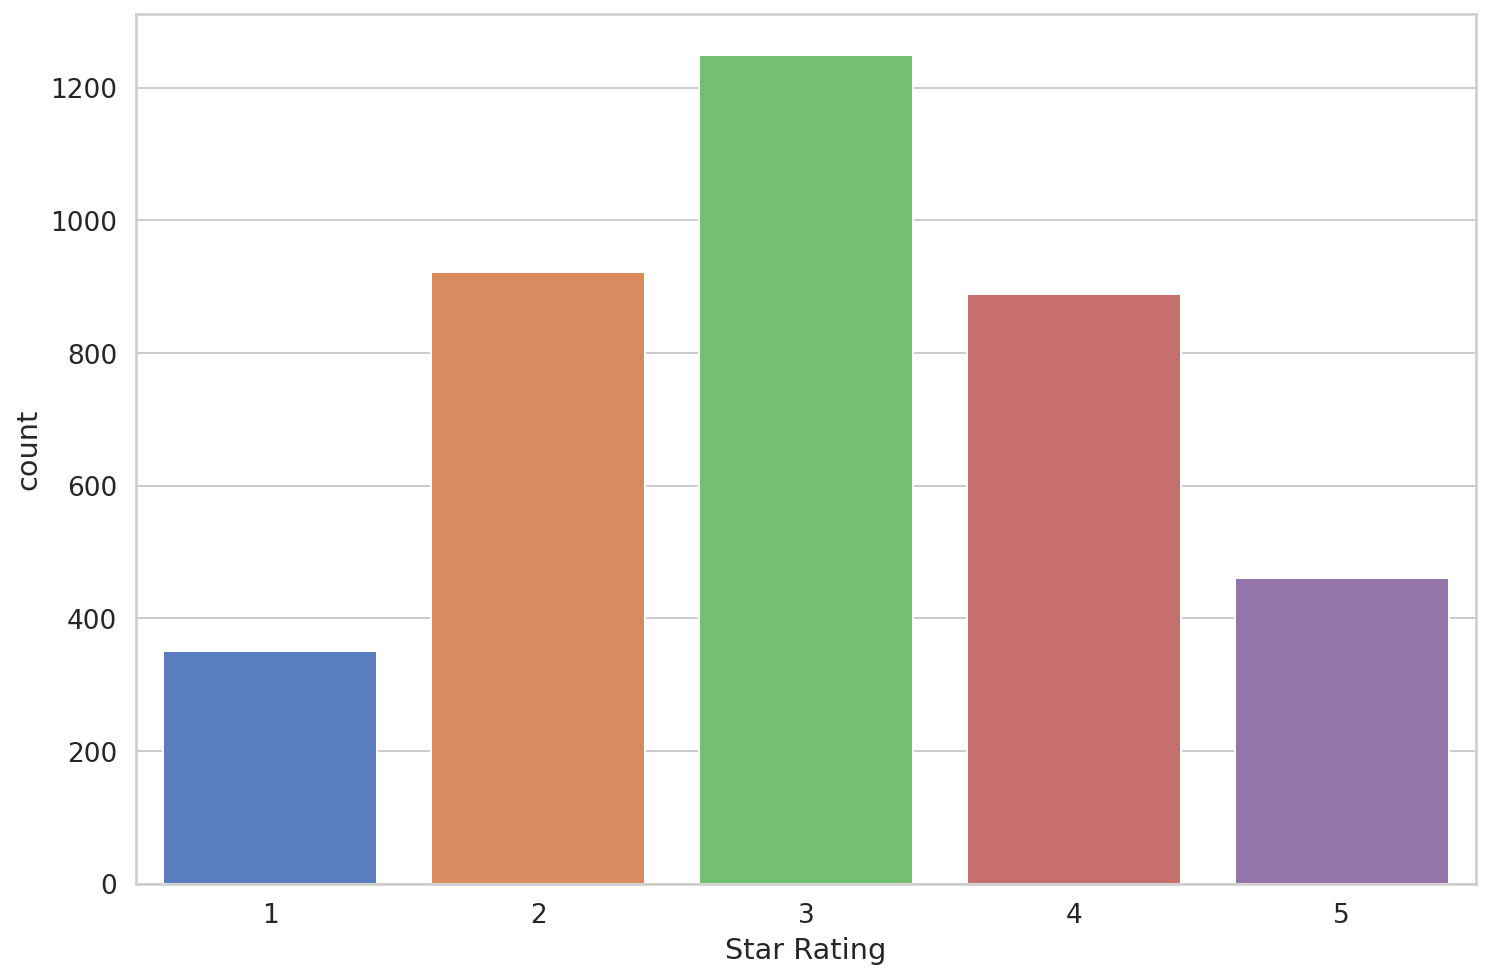

In [14]:
_ = sns.countplot(dataset['star_rating'])
plt.xlabel('Star Rating')

### Add `sentiment` column

Balance a bit the dataset by condensing the 1-2 as negative, the 4-5 as positive, keeping the neutral as neutral

In [15]:
def to_sentiment(rating):
  val = int(rating)

  if rating <= 2:
    return 0
  elif rating == 3:
    return 1
  else:
    return 2

In [16]:
dataset['sentiment'] = dataset['star_rating'].apply(to_sentiment)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


[Text(0, 0, 'Negative'), Text(0, 0, 'Neutral'), Text(0, 0, 'Positive')]

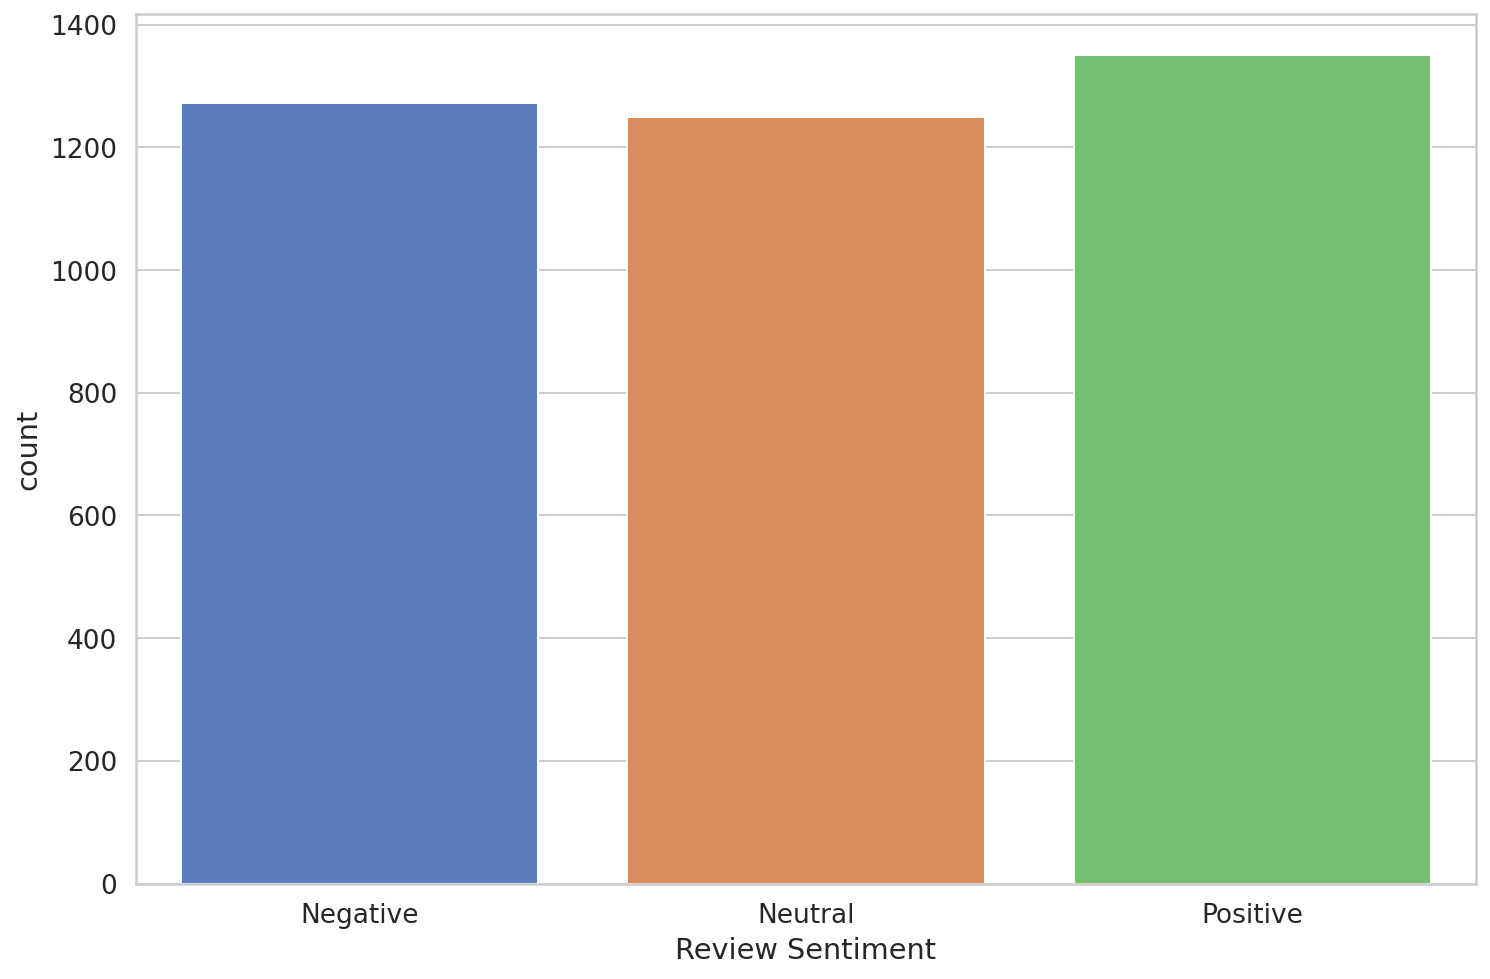

In [17]:
class_names = ['Negative', 'Neutral', 'Positive']

ax = sns.countplot(dataset['sentiment'])
plt.xlabel('Review Sentiment')
ax.set_xticklabels(class_names)

Now we have a quite balanced dataset

## Data preprocessing

In [18]:
PRE_TRAINED_MODEL_NAME = 'BSC-TeMU/roberta-base-bne'

In [19]:
from transformers import RobertaTokenizer

In [20]:
tokenizer = RobertaTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

Downloading:   0%|          | 0.00/1.15M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/509k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/772 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.46k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.46M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/613 [00:00<?, ?B/s]

### Choosing sequence length

In [21]:
token_lens = []

for s in dataset['review_body']:
  tokens = tokenizer.encode(s, max_length=512, truncation=True)
  token_lens.append(len(tokens))

Text(0.5, 11.552000000000007, 'Token count')

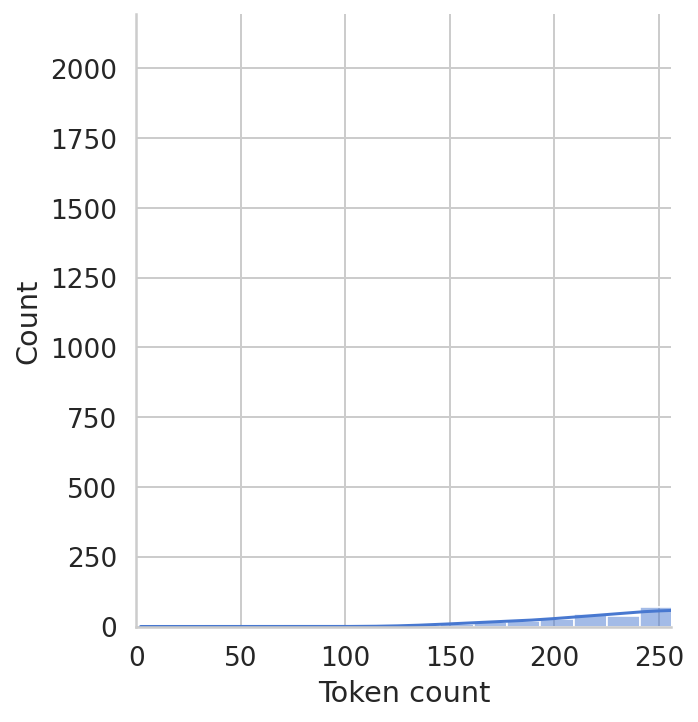

In [22]:
sns.displot(token_lens, kde=True)
plt.xlim([0,256])
plt.xlabel('Token count')

Most reviews tend to be quite larger in token count, so we are sticking to 256

In [23]:
MAX_LEN = 256

## Building the dataset object

In [24]:
import torch

In [25]:
RANDOM_SEED = 25

torch.manual_seed(RANDOM_SEED)

In [26]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [27]:
class MCReviewDataset(torch.utils.data.Dataset):

  def __init__(self, reviews, targets, tokenizer, max_len):
    self.reviews = reviews
    self.targets = targets
    self.tokenizer = tokenizer
    self.max_len = max_len

  def __len__(self):
    return len(self.reviews)

  def __getitem__(self, idx):
    review = str(self.reviews[idx])
    target = self.targets[idx]

    encoding = self.tokenizer.encode_plus(
        review,
        truncation=True,
        padding='max_length',
        add_special_tokens=True,
        max_length=self.max_len,
        return_token_type_ids=False,
        pad_to_max_length=True,
        return_attention_mask=True,
        return_tensors='pt'
    )

    return {
        'review_text': review,
        'input_ids': encoding['input_ids'].flatten(),
        'attention_mask': encoding['attention_mask'].flatten(),
        'targets': torch.tensor(target, dtype=torch.long)
    }


In [28]:
from sklearn.model_selection import train_test_split

In [29]:
train_set, test_set = train_test_split(
    dataset,
    test_size=0.1, 
    random_state=RANDOM_SEED
)

In [30]:
def create_data_loader(df, tokenizer, max_len, batch_size):
  ds = MCReviewDataset(
      reviews=df.review_body.to_numpy(),
      targets=df.sentiment.to_numpy(),
      tokenizer=tokenizer,
      max_len=max_len
  )

  return torch.utils.data.DataLoader(
      ds, batch_size=batch_size
  )

In [31]:
BATCH_SIZE = 16

In [32]:
train_data_loader = create_data_loader(train_set, 
                                       tokenizer,
                                       MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(test_set, 
                                      tokenizer,
                                      MAX_LEN, BATCH_SIZE)

In [33]:
data = next(iter(train_data_loader))
data.keys()

dict_keys(['review_text', 'input_ids', 'attention_mask', 'targets'])

In [34]:
data['input_ids'].shape, data['attention_mask'].shape, data['targets'].shape

(torch.Size([16, 256]), torch.Size([16, 256]), torch.Size([16]))

## Sentient Classification with BERT and hugging face

In [35]:
from transformers import RobertaModel

In [36]:
bert_model = RobertaModel.from_pretrained(PRE_TRAINED_MODEL_NAME)

Downloading:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of the model checkpoint at BSC-TeMU/roberta-base-bne were not used when initializing RobertaModel: ['lm_head.decoder.weight', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.bias', 'lm_head.decoder.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaModel were not initialized from the model checkpoint at BSC-TeMU/roberta-base-bne and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be ab

### Observing the model behaviour

In [37]:
sample_text = 'Hoy parece que lloverá'

sample_encoding = tokenizer.encode_plus(
    sample_text,
    max_length=MAX_LEN,
    add_special_tokens=True,
    return_token_type_ids=False,
    padding='max_length',
    pad_to_max_length=True,
    truncation=True,
    return_attention_mask=True,
    return_tensors='pt'
)

sample_encoding.keys()

dict_keys(['input_ids', 'attention_mask'])

In [38]:
sample_encoding['input_ids'][0] 

tensor([    0,  3025,  1918,   340, 38398,   351,     2,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1, 

In [39]:
sample_encoding['attention_mask']

tensor([[1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

In [40]:
hidden_states, pooled_output =  bert_model(
  input_ids=sample_encoding['input_ids'], 
  attention_mask=sample_encoding['attention_mask'],
  return_dict=False
)

In [41]:
bert_model.config.hidden_size

768

In [42]:
hidden_states.shape, pooled_output.shape

(torch.Size([1, 256, 768]), torch.Size([1, 768]))

In [43]:
from torch import nn

In [44]:
class SentimentClassifier(nn.Module):

  def __init__(self, n_classes):
    super(SentimentClassifier, self).__init__()
    self.bert = RobertaModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
    self.drop = nn.Dropout(p=0.3)
    self.out = nn.Linear(self.bert.config.hidden_size, n_classes)

  def forward(self, input_ids, attention_mask):
    _, pooled_output = self.bert(
        input_ids=input_ids,
        attention_mask=attention_mask,
        return_dict=False
    )

    # first_token_tensor = hidden_states[0]
    # pooled_output = self.dense(first_token_tensor)
    # pooled_output = self.activation(pooled_output)

    # print(f'pooled_output type: {type(pooled_output)}')

    output = self.drop(pooled_output)
    return self.out(output)

In [45]:
model = SentimentClassifier(len(class_names))
model = model.to(device)

Some weights of the model checkpoint at BSC-TeMU/roberta-base-bne were not used when initializing RobertaModel: ['lm_head.decoder.weight', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.bias', 'lm_head.decoder.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaModel were not initialized from the model checkpoint at BSC-TeMU/roberta-base-bne and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be ab

Moving the training batch to the device.

Batch Size: `batch_size` * `seq_len`

In [46]:
input_ids = data['input_ids'].to(device)
attention_mask = data['attention_mask'].to(device)

input_ids.shape, attention_mask.shape

(torch.Size([16, 256]), torch.Size([16, 256]))

To estimate the probabilities, we need to apply a softmax function to the output

In [47]:
import torch.nn.functional as F

In [48]:
F.softmax(model(input_ids, attention_mask), dim=1)

tensor([[0.3369, 0.3353, 0.3278],
        [0.3162, 0.3554, 0.3284],
        [0.3261, 0.3366, 0.3373],
        [0.3697, 0.3241, 0.3062],
        [0.3307, 0.3411, 0.3282],
        [0.3535, 0.3477, 0.2988],
        [0.3589, 0.3186, 0.3224],
        [0.3513, 0.3264, 0.3223],
        [0.3279, 0.3444, 0.3277],
        [0.3432, 0.3558, 0.3010],
        [0.3519, 0.3448, 0.3033],
        [0.3485, 0.3508, 0.3007],
        [0.3324, 0.3643, 0.3033],
        [0.3279, 0.3586, 0.3135],
        [0.3473, 0.3392, 0.3135],
        [0.3303, 0.3391, 0.3306]], device='cuda:0', grad_fn=<SoftmaxBackward>)

## Training the model

In [49]:
from transformers import AdamW, get_linear_schedule_with_warmup

In [50]:
EPOCHS = 10

optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss().to(device)

**Utility functions**

In [56]:
import numpy as np

In [51]:
def train_epoch(
    model, data_loader, loss_fn, optimizer, device, scheduler, n_examples
):
  model = model.train()
  losses = []
  correct_predictions = 0

  for d in data_loader:
    input_ids = d['input_ids'].to(device)
    attention_mask = d['attention_mask'].to(device)
    targets = d['targets'].to(device)

    outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
    )

    _, preds = torch.max(outputs, dim=1)
    loss = loss_fn(outputs, targets)

    correct_predictions += torch.sum(preds == targets)
    losses.append(loss.item())

    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()

  return correct_predictions.double() / n_examples, np.mean(losses)

In [52]:
def eval_model(
    model, data_loader, loss_fn, device, n_examples
):
  model = model.eval()
  losses = []
  correct_predictions = 0

  with torch.no_grad():
    for d in data_loader:
      input_ids = d['input_ids'].to(device)
      attention_mask = d['attention_mask'].to(device)
      targets = d['targets'].to(device)

      outputs = model(
          input_ids=input_ids,
          attention_mask=attention_mask
      )

      _, preds = torch.max(outputs, dim=1)
      loss = loss_fn(outputs, targets)

      correct_predictions += torch.sum(preds == targets)
      losses.append(loss.item())

  return correct_predictions.double() / n_examples, np.mean(losses)

In [53]:
from collections import defaultdict

### Training Loop

In [57]:
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [55]:
from tqdm import tqdm

In [61]:
%%time 

history = defaultdict(list)
best_accuracy = 0

for epoch in tqdm(range(EPOCHS), desc='Epoch'):
  # print(f'Epoch {epoch + 1}/{EPOCHS}')
  # print('=' * 10)

  train_acc, train_loss = train_epoch(
      model, train_data_loader, loss_fn, optimizer, device, scheduler, len(train_set)
  )

  print(f'Train loss: {train_loss}. Train accuracy: {train_acc}')

  val_acc, val_loss = eval_model(
      model, test_data_loader, loss_fn, device, len(test_set)
  )

  print(f'Validation loss: {val_loss}. Validation accuracy: {val_acc}')

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)

  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)
  
  if val_acc > best_accuracy:
    torch.save(model.state_dict(), 'best_model_state.bin')
    best_accuracy = val_acc

Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Train loss: 1.098709029888888. Train accuracy: 0.3493111366245695
Validation loss: 1.1129943466186523. Validation accuracy: 0.28350515463917525


Epoch:  10%|█         | 1/10 [05:27<49:05, 327.32s/it]

Train loss: 1.099352422657363. Train accuracy: 0.3587830080367394


Epoch:  20%|██        | 2/10 [10:52<43:28, 326.04s/it]

Validation loss: 1.11126455783844. Validation accuracy: 0.28350515463917525
Train loss: 1.1000512029052874. Train accuracy: 0.3493111366245695


Epoch:  30%|███       | 3/10 [16:17<38:00, 325.76s/it]

Validation loss: 1.108727340698242. Validation accuracy: 0.28350515463917525
Train loss: 1.0996844292780674. Train accuracy: 0.3541905855338691


Epoch:  40%|████      | 4/10 [21:43<32:33, 325.57s/it]

Validation loss: 1.1080693578720093. Validation accuracy: 0.28350515463917525
Train loss: 1.0982653323663485. Train accuracy: 0.3513203214695752


Epoch:  50%|█████     | 5/10 [27:08<27:07, 325.48s/it]

Validation loss: 1.1073182010650635. Validation accuracy: 0.28350515463917525
Train loss: 1.0985183551770832. Train accuracy: 0.35820895522388063


Epoch:  60%|██████    | 6/10 [32:33<21:41, 325.44s/it]

Validation loss: 1.107149863243103. Validation accuracy: 0.28350515463917525
Train loss: 1.0986739402517267. Train accuracy: 0.350459242250287


Epoch:  70%|███████   | 7/10 [37:59<16:16, 325.38s/it]

Validation loss: 1.1070721101760865. Validation accuracy: 0.28350515463917525
Train loss: 1.0980586852502385. Train accuracy: 0.3556257175660161


Epoch:  80%|████████  | 8/10 [43:24<10:50, 325.29s/it]

Validation loss: 1.1070721101760865. Validation accuracy: 0.28350515463917525
Train loss: 1.098097948853029. Train accuracy: 0.35361653272101035


Epoch:  90%|█████████ | 9/10 [48:49<05:25, 325.43s/it]

Validation loss: 1.1070721101760865. Validation accuracy: 0.28350515463917525
Train loss: 1.0988216257970267. Train accuracy: 0.3516073478760046


Epoch: 100%|██████████| 10/10 [54:17<00:00, 325.78s/it]

Validation loss: 1.1070721101760865. Validation accuracy: 0.28350515463917525
CPU times: user 53min 53s, sys: 28.2 s, total: 54min 21s
Wall time: 54min 17s


### Save model to GDrive

In [62]:
!zip torch_sentiment_roberto.zip best_model_state.bin

  adding: best_model_state.bin (deflated 12%)


In [63]:
!cp torch_sentiment_roberto.zip "/content/gdrive/MyDrive/proyectos/machine learning/sentiment_analysis"

### Evaluating the model

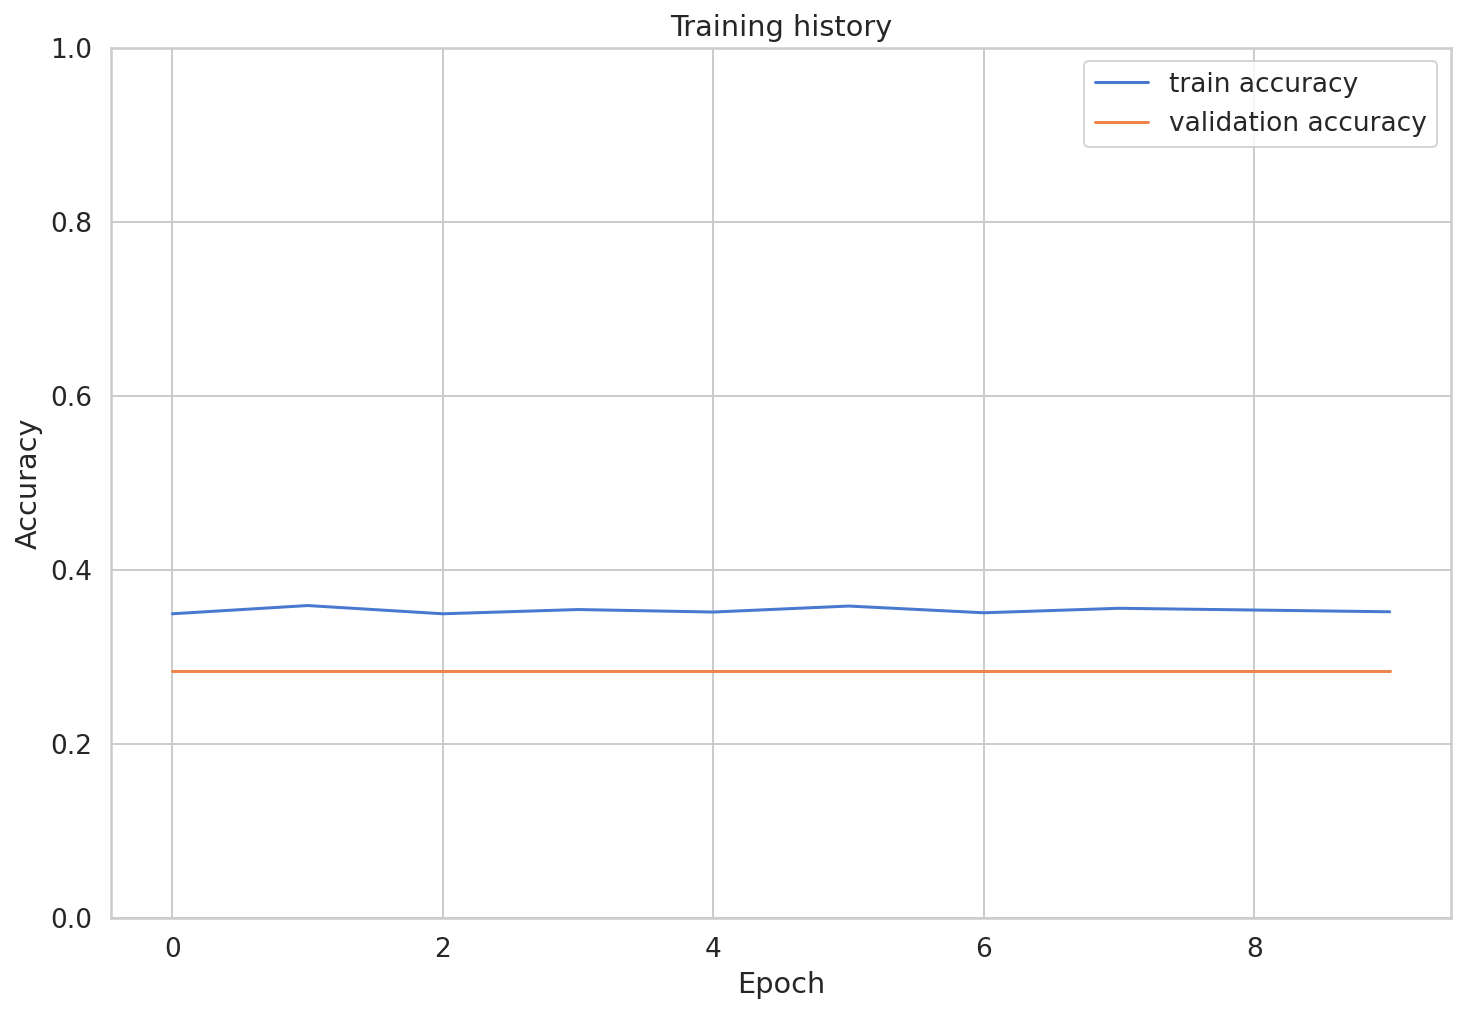

In [64]:
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')

plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

In [71]:
def get_predictions(model, data_loader):
  model = model.eval()
  
  review_texts = []
  predictions = []
  prediction_probs = []
  real_values = []

  with torch.no_grad():
    for d in data_loader:

      texts = d["review_text"]
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)

      probs = F.softmax(outputs, dim=1)

      review_texts.extend(texts)
      predictions.extend(preds)
      prediction_probs.extend(probs)
      real_values.extend(targets)

  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()
  real_values = torch.stack(real_values).cpu()
  return review_texts, predictions, prediction_probs, real_values

In [72]:
y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(
  model,
  test_data_loader
)

In [74]:
from sklearn.metrics import classification_report

In [75]:
print(classification_report(y_test, y_pred, target_names=class_names))

              precision    recall  f1-score   support

    Negative       0.00      0.00      0.00       140
     Neutral       0.00      0.00      0.00       138
    Positive       0.28      1.00      0.44       110

    accuracy                           0.28       388
   macro avg       0.09      0.33      0.15       388
weighted avg       0.08      0.28      0.13       388



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [79]:
from sklearn.metrics import confusion_matrix
import pandas as pd

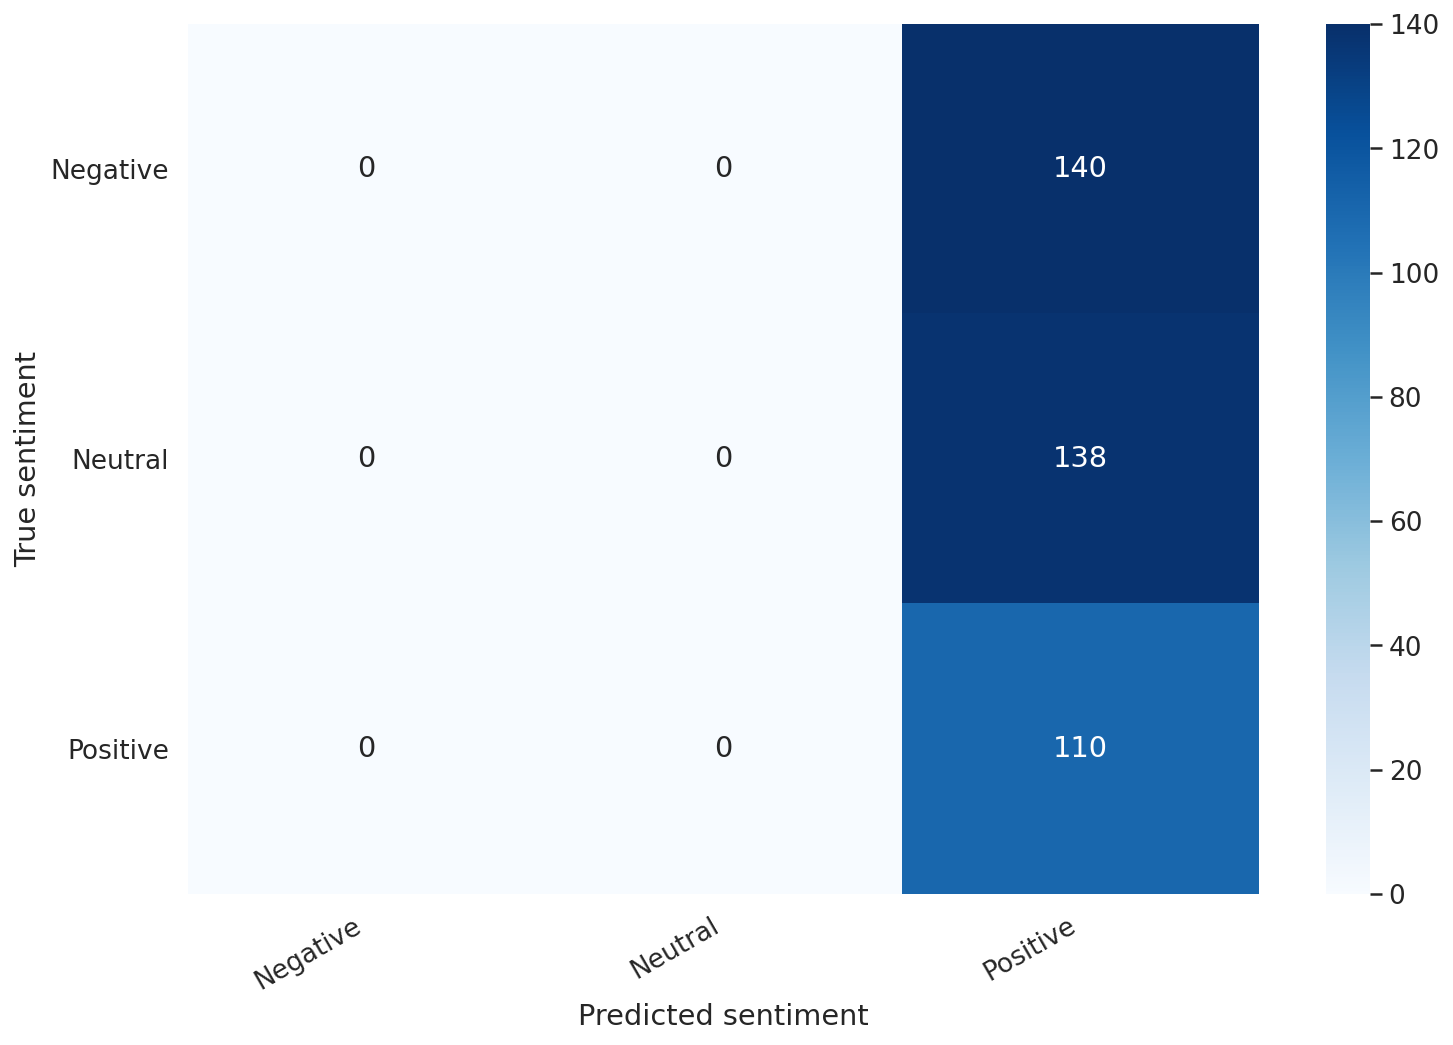

In [80]:
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True sentiment')
  plt.xlabel('Predicted sentiment');

cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)



### Manual Validation

In [83]:
from textwrap import wrap

In [86]:
print("\n".join(wrap(review_text)))
print()
print(f'True sentiment: {class_names[true_sentiment]}')

Cinta de acción simple, sin buscarle más de 3 pies al gato y que
repite en una y mil situaciones ya conocidas anteriormente, vamos, que
si en vez de a Wahlberg, ponemos a Chuck Norris, Stallone o incluso
Schwarzenegger tendríamos más o menos lo mismo que hemos visto en
pantalla.Antoine Fuqua (excelente en "Training Day" y mediocre en "El
Rey Arturo") consigue aqui plasmar con una similitud pasmosa infinidad
de momentos del género de acción, llegando uno incluso a "olerte" todo
lo que ocurre, en este Mix-genérico de acción, lástima de un director
que se le veía inmenso y ahora empieza a recordarme a lo más reciente
de John Singleton, otro que empezó de maravilla y ahora dirige bodrios
como la 2ª entrega de "A todo gas", aunque como bien dice un amigo mío
"Los directores también son seres humanos que pagan la hipoteca a fin
de mes".Es cierto que el arranque de la cinta es genial, y que a más
de uno le gustaría ponerse en las manos de uno de los francotiradores
que aparecen en pantalla (s

In [84]:
idx = 2

review_text = y_review_texts[idx]
true_sentiment = y_test[idx]
pred_df = pd.DataFrame({
  'class_names': class_names,
  'values': y_pred_probs[idx]
})

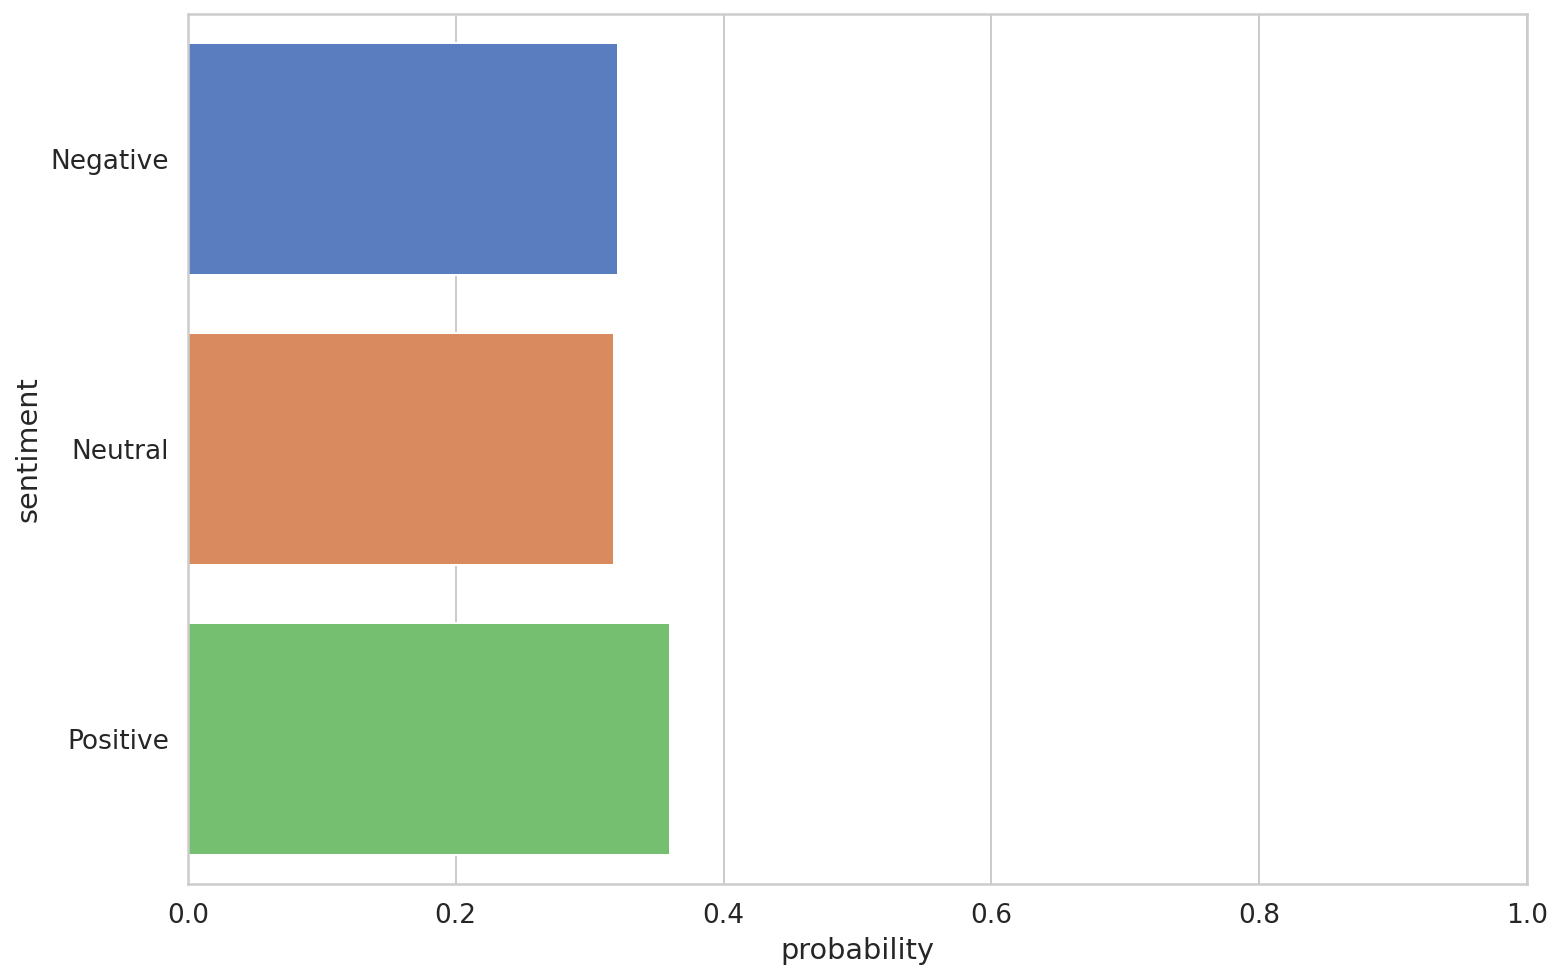

In [85]:
sns.barplot(x='values', y='class_names', data=pred_df, orient='h')
plt.ylabel('sentiment')
plt.xlabel('probability')
plt.xlim([0, 1]);